# Deep Unfolding applied to gradient descent
using: \
Julia 1.8.2 \
Flux.jl 0.13.6 \
Zygote.jl 0.6.49 \
Symbolics 5.10.0 \
\
In this Jupyter notebook, I explore applying Deep Unfolding (DU) to gradient descent algorithms. The notebook is based on Tadashi Wadayama's work found at https://github.com/wadayama/DU-Book/blob/main/Chapter_3/DU-GD.ipynb. 

Deep Unfolding treats iterative algorithms as if each iteration were a layer in a deep neural network. In this notebook, I consider applying DU to gradient descent, which iteratively modifies an input vector $x_k$ to minimize an objective function $f(x)$ using the recursive formula:

$$
x_{k+1} = x_k -\eta\cdot\nabla f(x_k),
$$

where $\nabla f(x)$ is the gradient of $f(x)$, and $\eta$ is the step size parameter. Here, $\eta$ is a parameter to be learned. 

I calculate $\nabla f(x)$ symbolically and use it in the recursive equation, converting it to a numerically evaluated function. Meanwhile, I calculate the gradient of the DU parameters (here just the scalar $\eta$) via automatic differentiation and optimize it using the Adam algorithm.

## A simple constant-parameter-learning example

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux
using Symbolics

Define an objective function to minimize. We use Symbolics package to compute the gradient of the function.

In [6]:
@variables x[1:2]

#f(x)=(1-x[1])^2+100*(x[2]-x[1]^2)^2 # Rosenbrock function
f(x) = x[1]^2+x[2]^2 # Quadratic function

g(x)=Symbolics.gradient(f(x),Symbolics.get_variables(f(x))) # compute symbolically the gradient of f(x)

g_expr = build_function(g(x),x) 
callable_gradient=eval(g_expr[1]) # we obtain a function that returns a numerical gradient
callable_gradient([1,1]) # sanity check

2-element Vector{Int64}:
 2
 2

Define a function that performs gradient descent. We will learn the step size $\eta$ or eta[1] (a scalar) using Deep Unfolding.

In [18]:
function GD_ki(max_itr, x0, eta)
    x = x0
    for i in 1:max_itr
        #df = gradient(() -> f(x), Flux.params(x)) 
        # The above line cannot be done because Flux.gradient cannot take gradient of itself.
        # We can hard-code df = 2*x or we can symbolically get the gradient and convert into a function 
        # returning numerical vector.
        
        x = x - eta[1].*callable_gradient(x)
    end
    return f(x)
end

GD_ki (generic function with 1 method)

Define the train function that does the "deep unfolding". Here we perform automatic differentiation of the gradient descent algorithm using Flux.gradient. 

In [19]:
function train_ki(opt, eta, max_itr, train_itr)
    ps = Flux.params(eta) 
    l = [] # will keep record of eta values in this list
    for i in 1:train_itr # perform gradient descent starting from train_iter random starting points
        push!(l,eta[1]) # like append in python
        gs = Flux.gradient(ps) do
            GD_ki(max_itr, randn(2), eta) # perform gradient descent for max_itr iterations 
        end
        Flux.Optimise.update!(opt, ps, gs)   
    end  
    return l
end

train_ki (generic function with 1 method)

We plot the history of $\eta$ with respect to training iteration. The optimization algorithm employed is ADAM. It converges to the optimal value of $\eta = 0.5$ for the quadratic function.

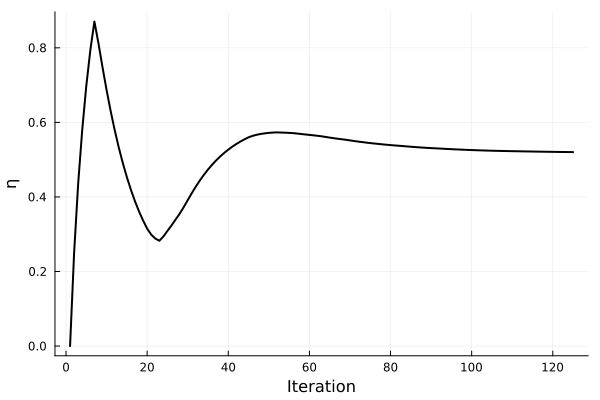

In [20]:
opt = Flux.ADAM(0.25) 
eta = [0.0]
max_itr = 2
train_itr = 125
l = train_ki(opt, eta, max_itr, train_itr)
plot(1:train_itr,l, xlabel="Iteration", ylabel="η",legend=false, lw=2,color=:black)